# Plot MPI-GE CMIP6 SIA

This notebook creates Fig. 1 with an overview of the SIA data in MPI-ESM2-1-LR verus CO<sub>2</sub> emissions and GMST.

## Setup

In [2]:
# General Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import re

# custom py files
from functions.variables import cc_ssps
import functions.helper as hlp
import functions.memberhandling as mbhl

In [ ]:
basepath = "/Users/quraus001/Documents/Uni/SIA-Sensitivity-Uncertainty/"
datapath = basepath + "data/"
plotpath = basepath + "Paper/"

save_plots = False

## Load Data

In [6]:
scenarios = ["ssp245","ssp370","ssp585"]

# Sea-ice area
DF_sia = {}
for scenario in scenarios:
    DF_sia[scenario] = mbhl.load_model_data(inpath=datapath + "MPI-ESM2-1-LR/sia_nh/", scenario=scenario)

# Global mean surface temperature
DF_gmst = {}
for scenario in scenarios:
    DF_gmst[scenario] = mbhl.load_model_data(inpath=datapath + "MPI-ESM2-1-LR/gmst/", scenario=scenario)-273.15
    DF_gmst[scenario] = DF_gmst[scenario] - DF_gmst[scenario].loc[1951:1980].mean()

# Create sorted member list
members = list(DF_sia["ssp245"].columns)[:-3]#mbhl.create_member_list("mb", zfill=3, N=50)
members = sorted(members, key=lambda x: int(re.search(r'r(\d+)i', x).group(1)))

# CO2 Data
cmip6_ds = xr.open_dataset(datapath +"co2/CMIP6_co2_emissions_ssp.nc")
df_co2 = cmip6_ds.to_dataframe().cumsum(axis=0)
df_co2.index = df_co2.index.astype(int)
df_co2

,ssp119,ssp126,ssp245,ssp370,ssp585
time,,,,,
1850,2.665337,2.665337,2.665337,2.665337,2.665337
1851,5.350075,5.350075,5.350075,5.350075,5.350075
1852,8.061351,8.061351,8.061351,8.061351,8.061351
1853,10.800027,10.800027,10.800027,10.800027,10.800027
1854,13.588079,13.588079,13.588079,13.588079,13.588079
...,...,...,...,...,...
2096,2706.720558,3427.763601,5130.141688,7400.632679,9678.963999
2097,2693.828200,3419.215596,5141.817007,7481.880477,9806.537988
2098,2680.603365,3410.644331,5152.828173,7563.620953,9933.683084


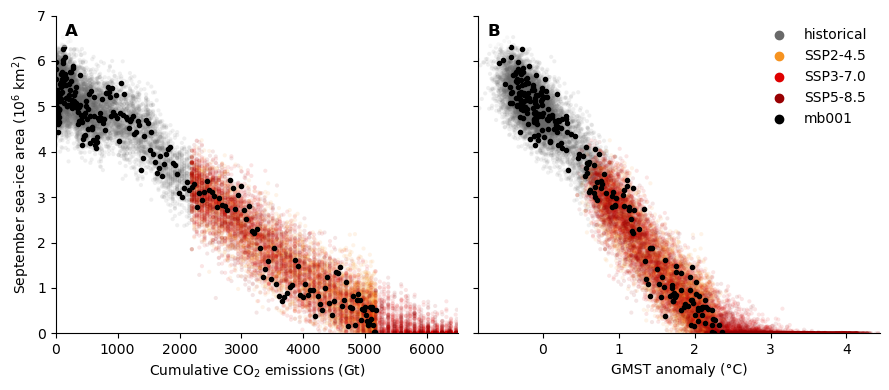

In [7]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(9,4),tight_layout=True, sharey=True)

Label = {"ssp245":"SSP2-4.5", "ssp370":"SSP3-7.0", "ssp585":"SSP5-8.5"}
alpha = 0.1

# Historical label
ax2.scatter(np.nan,np.nan, label = "historical",color=cc_ssps["historical"]) 

# Historical data points
for member in members:
    sia_hist = DF_sia[scenarios[0]][member].loc[:2014]
    ax2.scatter(DF_gmst[scenarios[0]][member].loc[:2014], sia_hist, color=cc_ssps["historical"], alpha=alpha, edgecolor="none", marker=".")
    ax1.scatter(df_co2[scenarios[0]].loc[1850:2014], sia_hist, color=cc_ssps["historical"], alpha=alpha, edgecolor="none",marker=".")

# Scenario data points
for scenario in scenarios:  
    ax2.scatter(np.nan, np.nan, label = Label[scenario], color=cc_ssps[scenario])
    for member in members:
        sia_rcp  = DF_sia[scenario][member].loc[2014:2100]
        ax2.scatter(DF_gmst[scenario][member].loc[2014:2100], sia_rcp, color=cc_ssps[scenario],alpha=alpha,edgecolor="none",marker=".")
        ax1.scatter(df_co2[scenario].loc[2014:2100], sia_rcp, color=cc_ssps[scenario],alpha=alpha,edgecolor="none",marker=".")

# Highlight one member
obs_member = members[0]
ax1.scatter(df_co2["ssp245"].loc[1850:2100], DF_sia["ssp245"][obs_member].loc[1850:2100], color="black",marker=".", label="mb001")
ax2.scatter(DF_gmst["ssp245"][obs_member].loc[1850:2100], DF_sia["ssp245"][obs_member].loc[1850:2100], color="black",marker=".")
ax2.scatter(np.nan, np.nan, label="mb001", color="black")

# Axes labels and limits
ax1.set_xlim(0,6500) 
ax1.set_xlabel(r"Cumulative CO$_2$ emissions (Gt)")
ax2.set_xlabel("GMST anomaly (°C)")
ax1.set_ylabel(r"September sea-ice area (10$^6$ km$^2$)")

# Subfigure labels
hlp.create_subfigure_label(ax1, "A", width=0.08, height=0.1, fontsize=12, box_alpha=0.5)
hlp.create_subfigure_label(ax2, "B", width=0.08, height=0.1, fontsize=12, box_alpha=0.5)

# Legends and styling
ax2.legend(frameon=False)
for ax in [ax1,ax2]:
    ax.margins(x=0)
    ax.set_ylim(0,7)    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

hlp.save_plot(plotpath + "MPI-ESM2-1-LR-all", save_plots, ["jpg"], dpi=300)